In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings;
warnings.filterwarnings('ignore');

### Dataset

In [2]:
import pandas as pd

df = pd.read_csv("result/01_date_preprocessing_result.csv",sep=",")
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text
0,0,purchase order day shipping amount receive pro...,1705,True,False,False,False,False,"[['purchase', 'order', 'day', 'shipping', 'amo..."
1,1,forwarded message date tue subject please inve...,904,True,False,False,False,False,"[['forwarded', 'message', 'date', 'tue', 'subj..."
2,2,forwarded message cc sent friday pdt subject f...,1230,False,False,False,False,True,"[['forwarded', 'message', 'cc', 'sent', 'frida..."
3,3,payment history missing credit report speciali...,903,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."
4,4,payment history missing credit report made mis...,851,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."


### Splitting Data

In [3]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45959 unique tokens.


In [4]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162411, 250)


In [5]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(103942, 250) (103942,)
(32483, 250) (32483,)


### Modeling

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Attention, MultiHeadAttention, Flatten,  Embedding, LSTM, Dense, GlobalMaxPooling1D, LayerNormalization, GlobalAveragePooling1D, Add

In [9]:
# Self-Attention Layer definition
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(SelfAttention, self).__init__()
        self.num_units = num_units
        self.query_dense = Dense(num_units)
        self.key_dense = Dense(num_units)
        self.value_dense = Dense(num_units)
        self.output_dense = Dense(num_units)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.sqrt(tf.cast(self.num_units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value)
        return self.output_dense(attention_output)

In [11]:
#fine tuning
num_heads = 4
num_units = 64
dropout_rate = 0.4

num_units_1 = 32
num_units_2 = 16
dropout_rate = 0.1

# Model definition
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

# First LSTM layer
lstm_layer1 = LSTM(num_units_1, return_sequences=True)(embedding_layer)

# First Self-Attention layer
attention_output1 = SelfAttention(num_units_1)(lstm_layer1)
add_layer1 = Add()([lstm_layer1, attention_output1])
norm_layer1 = LayerNormalization(epsilon=1e-6)(add_layer1)
dropout_layer1 = Dropout(dropout_rate)(norm_layer1)

# Second LSTM layer
lstm_layer2 = LSTM(num_units_2, return_sequences=True)(dropout_layer1)

# Second Self-Attention layer
attention_output2 = SelfAttention(num_units_2)(lstm_layer2)
add_layer2 = Add()([lstm_layer2, attention_output2])
norm_layer2 = LayerNormalization(epsilon=1e-6)(add_layer2)
dropout_layer2 = Dropout(dropout_rate)(norm_layer2)

# Global average pooling
global_avg_pooling = GlobalAveragePooling1D()(dropout_layer2)

# Dense output layer
output_layer = Dense(5, activation='softmax')(global_avg_pooling)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 250, 100)  │  5,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 250, 32)   │     17,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_2    │ (None, 250, 32)   │      4,224 │ lstm_2[0][0]      │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 250, 32)   │          0 │ lstm_2[0][0],     │
│                     │                   │            │ self_attention_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 32)   │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 250, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 250, 16)   │      3,136 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_3    │ (None, 250, 16)   │      1,088 │ lstm_3[0][0]      │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 250, 16)   │          0 │ lstm_3[0][0],     │
│                     │                   │            │ self_attention_3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 16)   │         32 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 250, 16)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_3[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 5)         │         85 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,025,653 (19.17 MB)

 Trainable params: 5,025,653 (19.17 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
num_epochs = 20
batch_size = 256
## For early stopping to ensure it doesnt overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.6907 - loss: 0.8873 - val_accuracy: 0.8659 - val_loss: 0.3983
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.8843 - loss: 0.3409 - val_accuracy: 0.8738 - val_loss: 0.3668
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.9062 - loss: 0.2755 - val_accuracy: 0.8638 - val_loss: 0.3970
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9188 - loss: 0.2409 - val_accuracy: 0.8540 - val_loss: 0.4400
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 582s 1s/step - accuracy: 0.9227 - loss: 0.2336 - val_accuracy: 0.8709 - val_loss: 0.4107


In [16]:
# Ambil loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

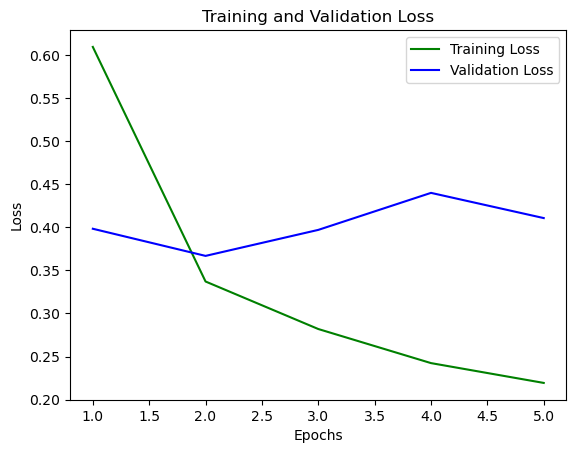

In [17]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Mengevaluasi kinerja model menggunakan data validasi
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Model Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - accuracy: 0.8755 - loss: 0.3602
Model Validation Accuracy: 0.8738166689872742


### Evaluating the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')